In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scripts.utils import load_csv, split_date, drop_columns, impute_rolling_median, add_seasonality, simplify_df, apply_moving_average_for_roc, split_data_frame, apply_functions
import tensorflow as tf
import time

### Preprocessing

In [2]:
df = load_csv('../data/btc_timeseries.csv')
df = split_date(df, 'time')
df = simplify_df(df)
df = drop_columns(df, 10.0)
df = impute_rolling_median(df, 5)
df = add_seasonality(df)
df = apply_moving_average_for_roc(df, 'ema', 10, 20)

/Users/lucapetracca/Documents/GitHub/Transformers-Financial-Time-Series-Forecasting/models/scripts/utils.py:153: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[column].fillna(method='bfill', inplace=True)  # Backfill to address initial NaNs


In [3]:
train, val, test = split_data_frame(df, 0.7, 0.2)

In [4]:
X_train, y_train, X_val, y_val, X_test, y_test = apply_functions(train, test, val)

/Users/lucapetracca/Documents/GitHub/Transformers-Financial-Time-Series-Forecasting/models/scripts/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = pd.to_datetime(df[column], format="%d-%m-%Y")
/Users/lucapetracca/Documents/GitHub/Transformers-Financial-Time-Series-Forecasting/models/scripts/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = pd.to_datetime(df[column], format="%d-%m-%Y")
/Users/lucapetracca/Documents/GitHub/Transformers-Financial-Time-Series-Foreca

In [5]:
from keras import layers

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0, epsilon=1e-6, attention_axes=None, kernel_size=1):
    """
    Creates a single transformer block.
    """
    x = layers.LayerNormalization(epsilon=epsilon)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout,
        attention_axes=attention_axes
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=epsilon)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=kernel_size, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=kernel_size)(x)
    return x + res

In [6]:
def build_transfromer(head_size, num_heads, ff_dim, num_trans_blocks, mlp_units, dropout=0, mlp_dropout=0, attention_axes=None, epsilon=1e-6, kernel_size=1):
    """
    Creates final model by building many transformer blocks.
    """
    n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], 1
    inputs = tf.keras.Input(shape=(n_timesteps, n_features))
    x = inputs
    for _ in range(num_trans_blocks):
        x = transformer_encoder(x, head_size=head_size, num_heads=num_heads, ff_dim=ff_dim, dropout=dropout, attention_axes=attention_axes, kernel_size=kernel_size, epsilon=epsilon)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)

    outputs = layers.Dense(n_outputs)(x)
    return tf.keras.Model(inputs, outputs)

In [7]:
transformer = build_transfromer(head_size=128, num_heads=4, ff_dim=2, num_trans_blocks=4, mlp_units=[256], mlp_dropout=0.10, dropout=0.10, attention_axes=1)

In [8]:
transformer.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 5, 18)]              0         []                            
                                                                                                  
 layer_normalization (Layer  (None, 5, 18)                36        ['input_1[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 multi_head_attention (Mult  (None, 5, 18)                38418     ['layer_normalization[0][0]', 
 iHeadAttention)                                                     'layer_normalization[0][0]'] 
                                                                                              

In [26]:
def fit_transformer(transformer: tf.keras.Model):
    """
    Compiles and fits our transformer.
    """
    transformer.compile(
        loss="mse",
        optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-3),
        metrics=["mae", 'mape'])

    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5)]
    start = time.time()
    hist = transformer.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=64, epochs=100, verbose=1, callbacks=callbacks).history
    print(time.time() - start)
    return hist

In [27]:
hist = fit_transformer(transformer)

Epoch 1/100
423/423 [==============================] - 10s 21ms/step - loss: 0.0146 - mae: 0.0777 - mape: 19.7233 - val_loss: 0.0188 - val_mae: 0.1273 - val_mape: 457.3661 - lr: 0.0010
Epoch 2/100
423/423 [==============================] - 10s 23ms/step - loss: 0.0038 - mae: 0.0473 - mape: 13.5434 - val_loss: 0.0085 - val_mae: 0.0868 - val_mape: 270.8933 - lr: 0.0010
Epoch 3/100
423/423 [==============================] - 10s 23ms/step - loss: 0.0029 - mae: 0.0411 - mape: 9.8718 - val_loss: 0.0053 - val_mae: 0.0651 - val_mape: 210.5728 - lr: 0.0010
Epoch 4/100
423/423 [==============================] - 10s 24ms/step - loss: 0.0024 - mae: 0.0371 - mape: 9.0436 - val_loss: 0.0034 - val_mae: 0.0518 - val_mape: 185.9240 - lr: 0.0010
Epoch 5/100
423/423 [==============================] - 10s 24ms/step - loss: 0.0022 - mae: 0.0349 - mape: 11.3180 - val_loss: 0.0030 - val_mae: 0.0499 - val_mape: 176.4426 - lr: 0.0010
Epoch 6/100
423/423 [==============================] - 10s 23ms/step - loss: 

In [28]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

def evaluate(model, X_test, y_test):
    model.evaluate(X_test, y_test, verbose=1)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    
    return mse, mae, mape
    
def plot_results(model, X_test, y_test):
    model.evaluate(X_test, y_test, verbose=1)
    y_pred = model.predict(X_test)
    # Plotting
    plt.figure(figsize=(15, 6))
    plt.plot(y_test, label='Actual Values')
    plt.plot(y_pred, label='Predicted Values')
    plt.title('Comparison of Actual and Predicted Values')
    plt.xlabel('Sample Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

846/846 [==============================] - 3s 3ms/step


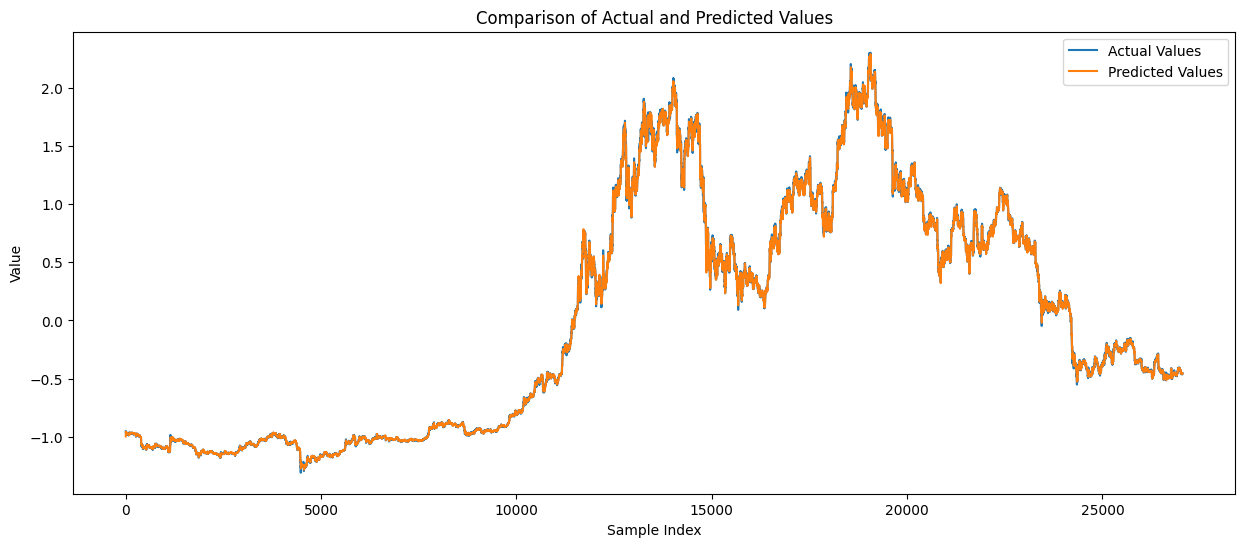

In [29]:
plot_results(transformer, X_train, y_train)

242/242 [==============================] - 1s 3ms/step


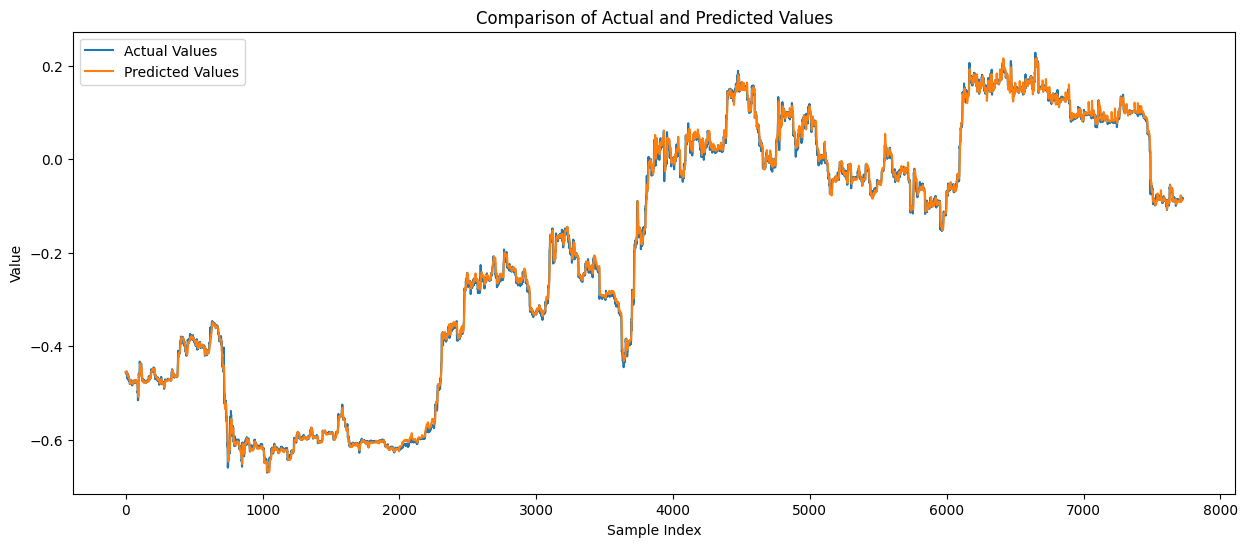

In [30]:
plot_results(transformer, X_val, y_val)

121/121 [==============================] - 0s 3ms/step


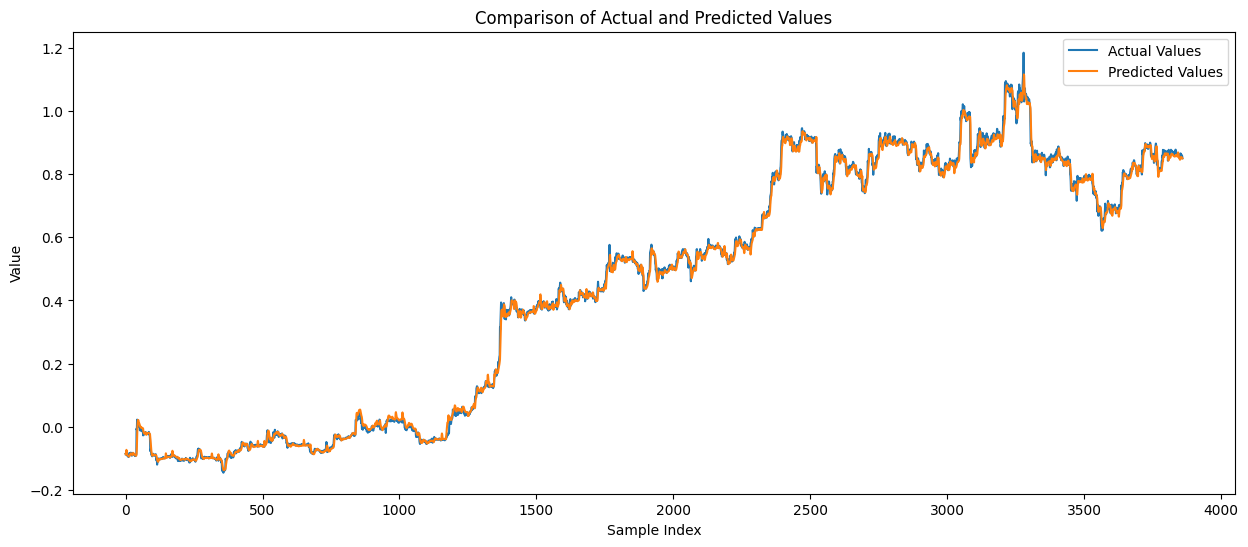

In [31]:
plot_results(transformer, X_test, y_test)

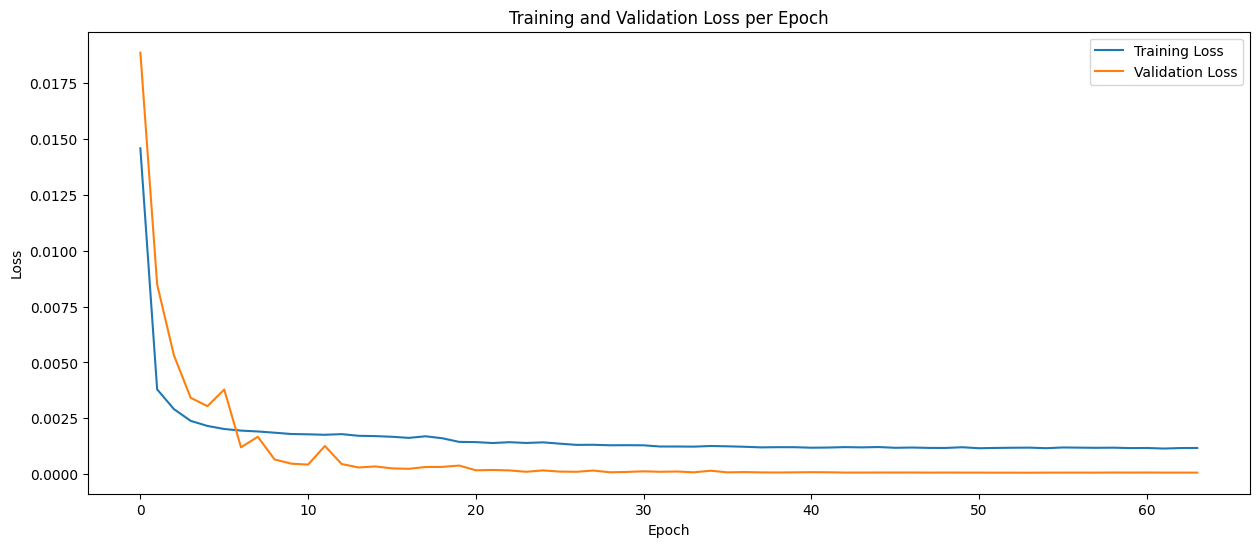

In [32]:
# Extracting loss data from the history object
train_loss = hist['loss']
val_loss = hist['val_loss']

# Number of epochs actually completed (may be less than 50 due to early stopping)
epochs = range(len(train_loss))

# Plotting the loss per epoch
plt.figure(figsize=(15, 6))
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [33]:
summary = []

crypto = 'BTC'
transformer_model = 'Transformer'
mse, mae, mape = evaluate(transformer, X_test, y_test)

summary.append({
    'Data': crypto,
    'Model': transformer_model,
    'MSE': mse,
    'MAE': mae,
    'MAPE': mape
})

# Convert list to DataFrame
tr_df = pd.DataFrame(summary)
tr_df

121/121 [==============================] - 0s 3ms/step


,Data,Model,MSE,MAE,MAPE
0,BTC,Transformer,0.00019,0.009211,0.187608
